In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random

## Define the paths

In [ ]:
# Define the paths
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'

# Classes
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Function to count images in each class
def count_images_in_classes(base_path, classes):
    counts = {}
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        counts[cls] = len(os.listdir(class_path))
    return counts

# Count images in training and testing sets
training_counts = count_images_in_classes(training_path, classes)
testing_counts = count_images_in_classes(testing_path, classes)


In [ ]:
# Plotting the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()



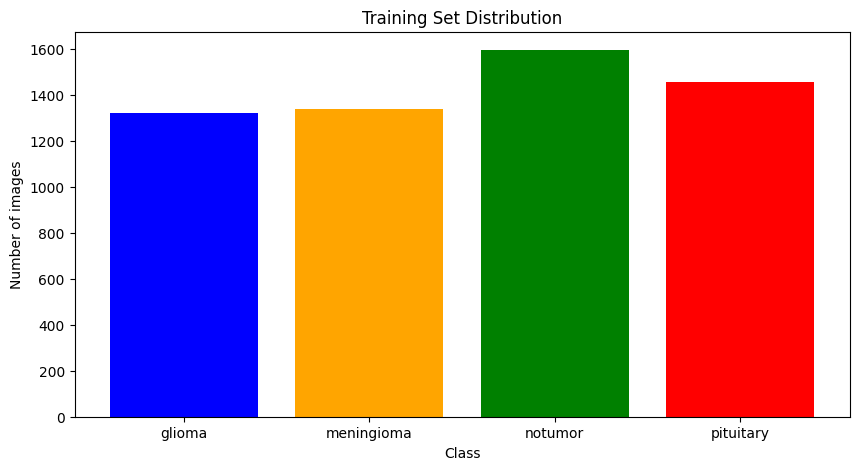

In [ ]:
# Plot distributions
plot_distribution(training_counts, 'Training Set Distribution')



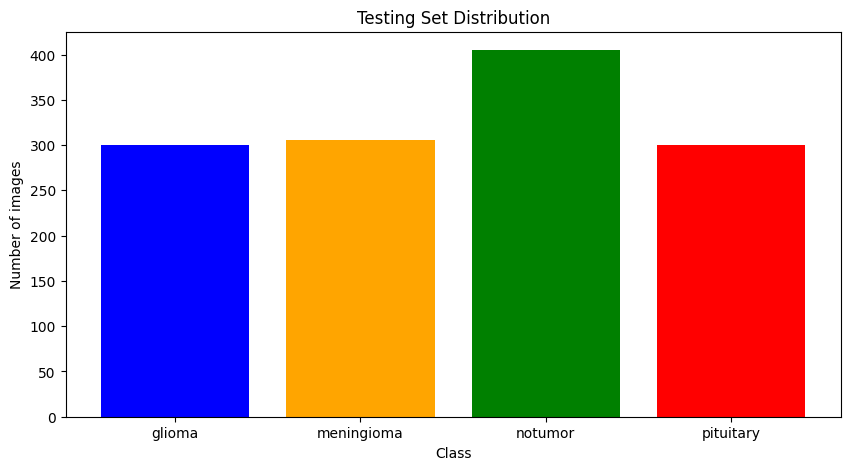

In [ ]:
plot_distribution(testing_counts, 'Testing Set Distribution')

## Display sample images

In [ ]:
# Function to display sample images from each class
def display_sample_images(base_path, classes, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(base_path, cls)
        images = os.listdir(class_path)
        for j in range(num_samples):
            img_path = os.path.join(class_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


## Training set Sample images

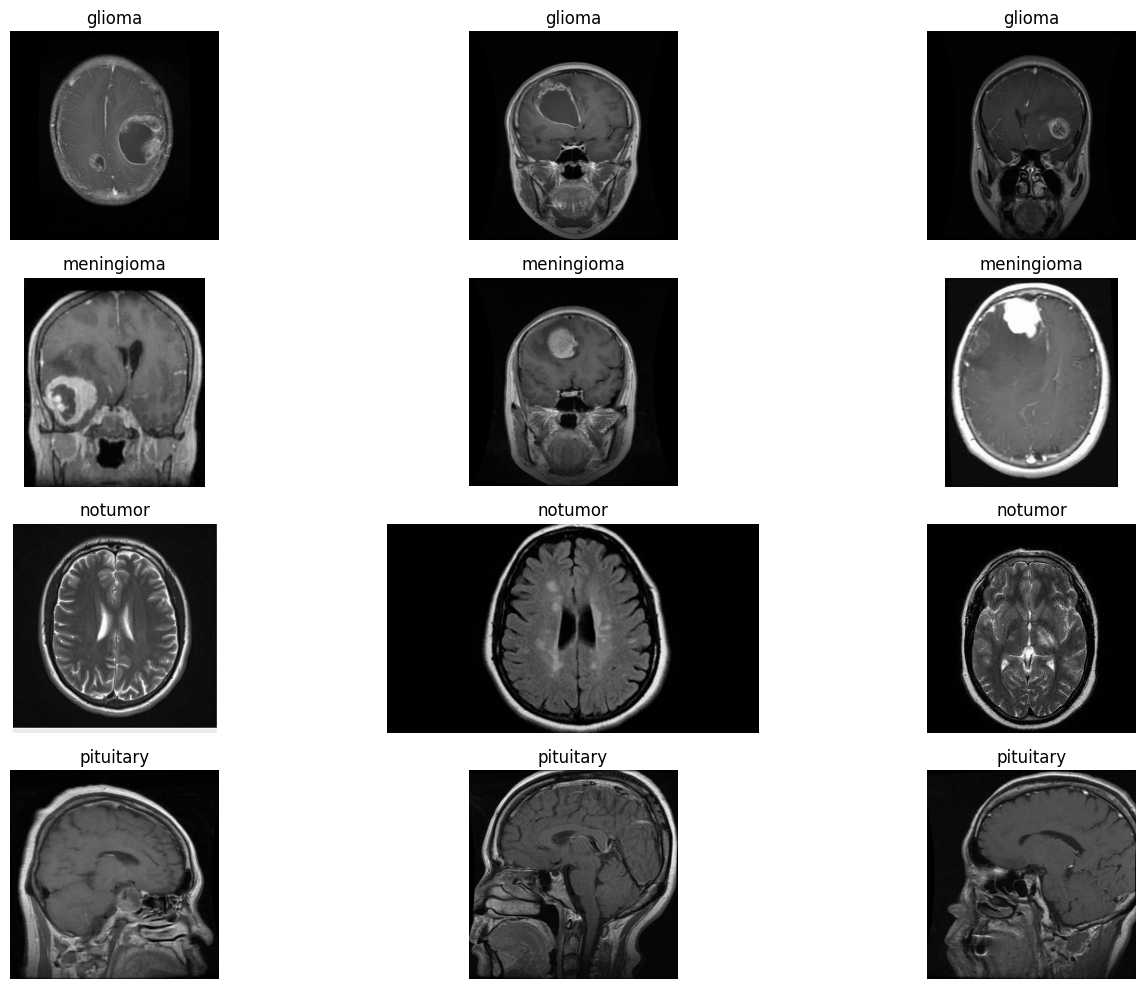

In [ ]:
# Display sample images from training set
display_sample_images(training_path, classes)



## Testing set Sample images

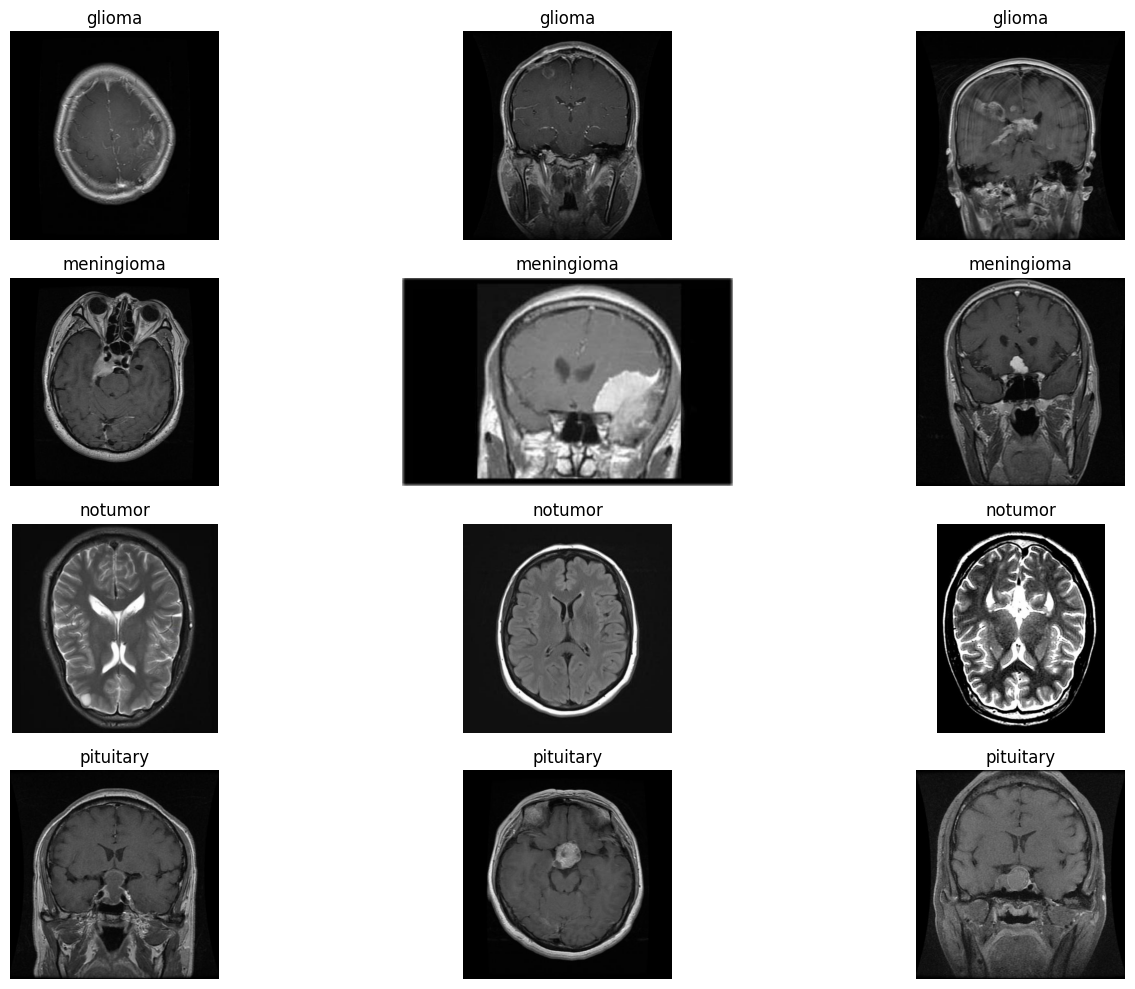

In [ ]:
# Display sample images from testing set
display_sample_images(testing_path, classes)


## Image properties

In [ ]:
# Function to check image properties
def check_image_properties(base_path, classes):
    properties = []
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        img_path = os.path.join(class_path, os.listdir(class_path)[0])
        img = cv2.imread(img_path)
        properties.append((cls, img.shape))
    return properties

# Check image properties
training_properties = check_image_properties(training_path, classes)
testing_properties = check_image_properties(testing_path, classes)



In [ ]:
print("Training set image properties:")
for cls, prop in training_properties:
    print(f"Class: {cls}, Image Shape: {prop}")



Training set image properties:
Class: glioma, Image Shape: (512, 512, 3)
Class: meningioma, Image Shape: (512, 512, 3)
Class: notumor, Image Shape: (417, 428, 3)
Class: pituitary, Image Shape: (256, 256, 3)


In [ ]:
print("\nTesting set image properties:")
for cls, prop in testing_properties:
    print(f"Class: {cls}, Image Shape: {prop}")


Testing set image properties:
Class: glioma, Image Shape: (512, 512, 3)
Class: meningioma, Image Shape: (225, 225, 3)
Class: notumor, Image Shape: (218, 236, 3)
Class: pituitary, Image Shape: (512, 512, 3)


## Model Training

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [2]:
# Define image dimensions and paths
img_height, img_width = 227, 227
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'

# Define data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [3]:
# Function to create model
def create_model(num_conv_layers=1, num_fc_layers=1, activation='relu', learning_rate=0.0001, momentum=0.9, l2_reg=0.001):
    model = Sequential()
    input_shape = (img_height, img_width, 3)

    # Add convolutional layers
    for _ in range(num_conv_layers):
        model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    model.add(Flatten())

    # Add fully connected layers
    for _ in range(num_fc_layers):
        model.add(Dense(512, kernel_regularizer=l2(l2_reg)))
        model.add(ReLU())
        model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [4]:
# Create the model
model = create_model(num_conv_layers=3, num_fc_layers=1, activation='relu', learning_rate=0.0001, momentum=0.9, l2_reg=0.001)


In [5]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 227, 227, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 227, 227, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 113, 113, 32)      1

In [6]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    validation_data=validation_generator,
    validation_steps=8,
    epochs=10
)

Epoch 1/10
8/8 [==============================] - 152s 18s/step - loss: 2.7655 - accuracy: 0.2695 - val_loss: 2.4520 - val_accuracy: 0.2773
Epoch 2/10
8/8 [==============================] - 110s 15s/step - loss: 2.2263 - accuracy: 0.5378 - val_loss: 2.4396 - val_accuracy: 0.4492
Epoch 3/10
8/8 [==============================] - 88s 12s/step - loss: 2.0171 - accuracy: 0.5898 - val_loss: 2.4458 - val_accuracy: 0.4688
Epoch 4/10
8/8 [==============================] - 84s 12s/step - loss: 2.0529 - accuracy: 0.6328 - val_loss: 2.4613 - val_accuracy: 0.4531
Epoch 5/10
8/8 [==============================] - 63s 8s/step - loss: 1.8946 - accuracy: 0.6914 - val_loss: 2.4927 - val_accuracy: 0.3047
Epoch 6/10
8/8 [==============================] - 44s 6s/step - loss: 1.7820 - accuracy: 0.6953 - val_loss: 2.5305 - val_accuracy: 0.3867
Epoch 7/10
8/8 [==============================] - 41s 5s/step - loss: 1.6839 - accuracy: 0.7852 - val_loss: 2.5921 - val_accuracy: 0.3203
Epoch 8/10
8/8 [============

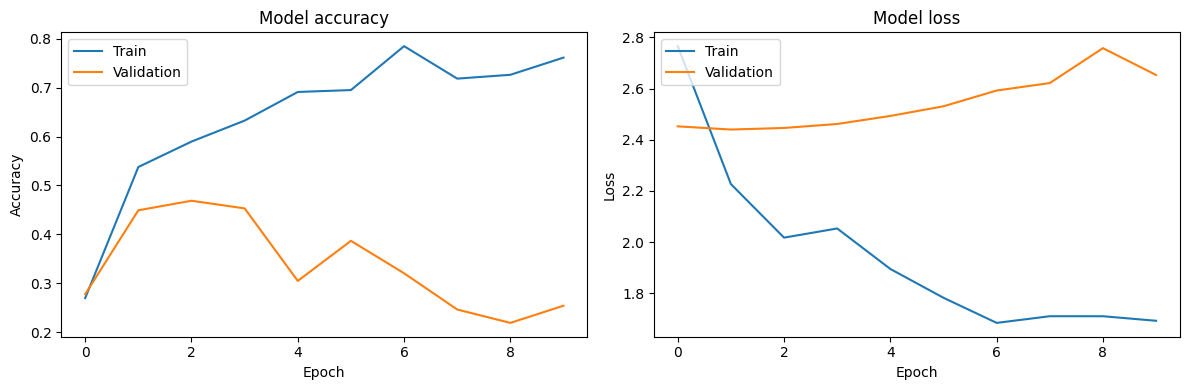

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()